# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [25]:
# Imports here
import numpy as np
import collections

from glob import glob
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchvision.models as models
from torch import nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from PIL import Image
import torchvision.transforms as transforms
from torch import optim

import PIL

import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [26]:
data_dir = '/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

batch_size=32
#tst_files = np.array(glob(data_dir+ '/*/*/*'))

dataset sizes {'train': 6552, 'valid': 818}


============================ class to idx ==========

1 - 0
10 - 1
100 - 2
101 - 3
102 - 4
11 - 5
12 - 6
13 - 7
14 - 8
15 - 9
16 - 10
17 - 11
18 - 12
19 - 13
2 - 14
20 - 15
21 - 16
22 - 17
23 - 18
24 - 19
25 - 20
26 - 21
27 - 22
28 - 23
29 - 24
3 - 25
30 - 26
31 - 27
32 - 28
33 - 29
34 - 30
35 - 31
36 - 32
37 - 33
38 - 34
39 - 35
4 - 36
40 - 37
41 - 38
42 - 39
43 - 40
44 - 41
45 - 42
46 - 43
47 - 44
48 - 45
49 - 46
5 - 47
50 - 48
51 - 49
52 - 50
53 - 51
54 - 52
55 - 53
56 - 54
57 - 55
58 - 56
59 - 57
6 - 58
60 - 59
61 - 60
62 - 61
63 - 62
64 - 63
65 - 64
66 - 65
67 - 66
68 - 67
69 - 68
7 - 69
70 - 70
71 - 71
72 - 72
73 - 73
74 - 74
75 - 75
76 - 76
77 - 77
78 - 78
79 - 79
8 - 80
80 - 81
81 - 82
82 - 83
83 - 84
84 - 85
85 - 86
86 - 87
87 - 88
88 - 89
89 - 90
9 - 91
90 - 92
91 - 93
92 - 94
93 - 95
94 - 96
95 - 97
96 - 98
97 - 99
98 - 100
99 - 101


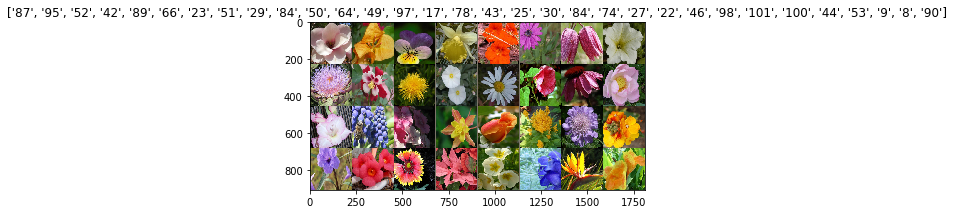

In [33]:
# TODO: Define your transforms for the training and validation sets
# note from pelit: used article https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(45),              
        #transforms.RandomResizedCrop(224),       
        #transforms.RandomHorizontalFlip(), 
         
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),   
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(root=train_dir,transform=data_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir,transform=data_transforms['valid'])
    #'test' : 
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=batch_size)
    #'test' : DataLoader(image_datasets['test'],batch_size = batch_size)    
}

def debug_img(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated

def debug_images(dataloaders):
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
    class_names = image_datasets['train'].classes # copied from pytorch tutorial, but here it's number, not really name
    print("dataset sizes", dataset_sizes)
    inputs, classes = next(iter(dataloaders['train']))
    out = torchvision.utils.make_grid(inputs)
    debug_img(out, title=[class_names[x] for x in classes])
    #imshow1(out, title=[x for x in classes])
    
debug_images(dataloaders)
print('============================ class to idx ==========\n')
for key,val in image_datasets['train'].class_to_idx.items():
    print(key, "-", val)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [19]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
#print("number of categories: ", len(cat_to_name))

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [20]:
# TODO: Build and train your network
# partially used https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/  

lr = 0.003
lr_step = 7 # decary the lr every X number of epochs
lr_gamma=0.1
momentum=0.9
epochs = 2
#dropout=0.5
#validation_freq=500
pu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#criteria = nn.NLLLoss() # matches softmax according to lecture
criteria= nn.CrossEntropyLoss()
frozen_layers_num=30
checkpoint_file='checkpoint.pth'

def save_checkpoint(model, filename, debug):
    checkpoint={
        'state_dict': model.state_dict(),
        'debug':str(debug),
        'class_to_idx': image_datasets['train'].class_to_idx #gloabal variable, I don't like it
    }
    torch.save(checkpoint, filename)
    
def freeze_layers(model, firstLayersToFreeze):
    ct = 0
    for name, child in model.named_children():
        ct += 1
        if ct < firstLayersToFreeze:
            for name2, params in child.named_parameters():
                params.requires_grad = False

def freeze_layers_all(model):
    for prm in model.parameters():
        prm.requires_grad = False
    
def make_model():
    # model1=models.vgg16(pretrained=True)
    model1=models.resnet152(pretrained=True)
    #print('=================== model before =====\n', model1, '\n======================= end model before=============')
    
    # make sure the pretrained weights are left alone:
    freeze_layers(model1, frozen_layers_num )
    
    # for vgg19/16:
    '''model1.classifier = nn.Sequential(collections.OrderedDict([
                        ('fc1', nn.Linear(25088, 4096)),
                        ('relu1', nn.ReLU()),
                        ('dropout1', nn.Dropout(p=dropout)),
                        ('fc2', nn.Linear(4096, 4096)),
                        ('relu2', nn.ReLU()),
                        ('dropout2', nn.Dropout(p=dropout)),
                        ('output', nn.Linear(4096, 102)),
                        ('softmax', nn.LogSoftmax(dim=1))
                        ]))'''
    # for resnet:
    model1.fc = nn.Linear(model1.fc.in_features, 102)
    return model1

# TODO pelit - consider uniting some code with 'train'
def do_validation(model, valid_loader, criteria):
    running_loss = 0
    running_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(valid_loader):
            images=images.to(pu)
            labels=labels.to(pu)
            output = model.forward(images)
            loss = criteria(output, labels)
            _, predicts = torch.max(output.data, 1)
            running_loss += loss.item()* images.size(0)
            running_acc += (predicts == labels).sum().item()      
    return running_loss/len(valid_loader.dataset), running_acc/len(valid_loader.dataset)

def acc_is_better_than(acc1, acc2):
    if acc1['validAcc']> acc2['validAcc']:
        return True
    if acc1['validAcc'] < acc2['validAcc']:
        return False
    # if validAcc is the same, then look into trainValie:
    return acc1['trainAcc'] > acc2['trainAcc']
    
def do_training(epochs, model, optimizer, scheduler, criteria, dataloaders):
    train_loader=dataloaders['train']
    valid_loader=dataloaders['valid']
    model.to(pu) 

    print('Starting train: pu={} epochs={}'.format(pu, epochs))      
    bestAcc={'validAcc':-1, 'trainAcc':-1}
    for ep in range(epochs):
        running_train_loss = 0
        running_train_acc=0
        scheduler.step() # new epoch, possible lr decay
        
        for idx, (images, labels) in enumerate(train_loader):
            #print('...starting epoch:{} step:{}'.format(ep, steps))
            images=images.to(pu)
            labels=labels.to(pu)
            model.train() # this affects things like dropout

            optimizer.zero_grad() # reset the gradient calc for this epoch
            outputs = model.forward(images)
            loss = criteria(outputs, labels)
            loss.backward()     # back propagation
            optimizer.step()    # weights fixing step
    
            # error calculations:
            _, predicts = torch.max(outputs.data, 1)
            running_train_loss += loss.item() * images.size(0)
            running_train_acc += (predicts == labels).sum().item()
        
        # after one epoc iteration on the entire data, collect TRAIn epoch stats:
        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = running_train_acc / len(train_loader.dataset)   
        valid_loss, valid_acc = do_validation(model, valid_loader, criteria)           
        print('Epoch={} trainLoss={:.4f} trainAcc={:.4f} validLoss={:.4f} validAcc={:.4f}'.format(
            ep, train_loss, train_acc, valid_loss, valid_acc))
    
        currAcc={'trainAcc':train_acc, 'validAcc':valid_acc}
        if acc_is_better_than(currAcc, bestAcc):
            bestAcc= currAcc
            save_checkpoint(model, checkpoint_file, currAcc)
            
# ===========================
# main training execution!
# ===========================
model=make_model()
#print('model', model)
#optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=momentum)
scheduler = lr_scheduler.StepLR(optimizer,lr_step, lr_gamma)
do_training(epochs, model, optimizer, scheduler, criteria, dataloaders)

Starting train: pu=cuda:0 epochs=2


Epoch=0 trainLoss=3.0794 trainAcc=0.3968 validLoss=1.8291 validAcc=0.6846


Epoch=1 trainLoss=1.4454 trainAcc=0.7656 validLoss=1.0542 validAcc=0.8521


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [21]:
# TODO: Save the checkpoint 
# Called during the training iter!


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [22]:
def load_model(filename):
    checkpoint = torch.load(filename)
    model = make_model()
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx=checkpoint['class_to_idx']
    return model
    

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    image_obj = PIL.Image.open(image)
    orig_width, orig_height = image_obj.size

    # Find the shorter dimension, it will be cropped to 256
    if orig_width < orig_height: 
        resize_size=[256, 256**600]
    else: 
        resize_size=[256**600, 256]
    
    #using theumbnail approach from documentation:
    image_obj.thumbnail(size=resize_size)

    # Crop to get 224x224 :
    center = orig_width/4, orig_height/4
    left, top, right, bottom = center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    image_obj = image_obj.crop((left, top, right, bottom))

    # Numpy array (width and height are 244x244, depth is 3 for RGG colours):
    np_image = np.array(image_obj)
    # normalization:
    np_image= np_image / 255  # yields values between 0..1 
    normalise_means = [0.485, 0.456, 0.406]
    normalise_std = [0.229, 0.224, 0.225]
    np_image = (np_image-normalise_means)/normalise_std
        
    # Set the color to the 1st channel
    np_image = np_image.transpose(2, 0, 1)
    return np_image
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

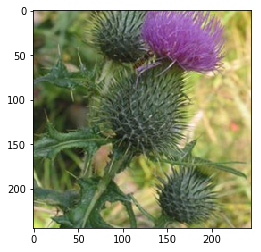

In [24]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image(valid_dir + '/14/image_06082.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    pu = "cpu" # following instructions for udacity rubric
    
    model.to(pu) 
    model.eval()
    img=process_image(image_path)
    img=torch.from_numpy(img)
    img = img.unsqueeze(0) # flatten, so as to feed into the nn
    probabilities = model.forward(img)
    probabilities=F.softmax(predicts.data,dim=1)    
    probabilities_top=  probabilities.topk(topk) 
    
    # Convert output from indexes to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()} # reversed mapping
    top_labels = [idx_to_class[lab] for lab in top_labels]
    #top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers    

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes